# CIFAR-100 CNN  Multihead Classification

In [ ]:
from torchvision.models import mobilenet_v2

def create_backbone():
    return mobilenet_v2(pretrained=True)

NUM_EPOCHS = 1000 
PATIENCE = 20

TRAIN_SPLIT_RATIO = 0.8

BATCH_SIZE = 256
LEARNING_RATE = 0.001
NUM_WORKERS = 4

RANDOM_SEED = 42

In [2]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
        
        return self.early_stop


class SaveModel:
    def __init__(self):
        self.best_loss = None
        
    def should_save(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            return True
        return False
    
    def save(self, model, optimizer, epoch, train_loss, val_loss, filename, **kwargs):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }
        checkpoint.update(kwargs)
        
        torch.save(checkpoint, filename)
        print(f"Checkpoint saved: {filename}")


In [3]:
import torch
import torchvision
from torchvision.datasets import CIFAR100

In [4]:
import matplotlib.pyplot as plt
import numpy as np

train_dataset = CIFAR100(root='./data', train=True, download=True, transform=None)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=None)


for dataset, dataset_name in [[train_dataset, "train"], [test_dataset, "test"]]:
    print(f"Dataset {dataset_name} size: {len(dataset)}")
    print(f"Image shape: {dataset[0][0].size}")
    print(f"Number of classes: {len(dataset.classes)}")
    print("\n")

class_names = list(set(train_dataset.classes))
print("\n")
print("Some of the class names: ")
for class_name in class_names[:10]:
    print(class_name)


print("\n")
print(f"Length of class names: {len(train_dataset.classes)}")
print("\n")
print("All class names: ")
print(train_dataset.classes)

Dataset train size: 50000
Image shape: (32, 32)
Number of classes: 100


Dataset test size: 10000
Image shape: (32, 32)
Number of classes: 100




Some of the class names: 
train
snake
bridge
lamp
boy
camel
cockroach
mountain
chimpanzee
dolphin


Length of class names: 100


All class names: 
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road'

In [5]:
FINE_TO_COARSE_MAPPING = {
    4: 0, 30: 0, 55: 0, 72: 0, 95: 0,
    1: 1, 32: 1, 67: 1, 73: 1, 91: 1,
    54: 2, 62: 2, 70: 2, 82: 2, 92: 2,
    9: 3, 10: 3, 16: 3, 28: 3, 61: 3,
    0: 4, 51: 4, 53: 4, 57: 4, 83: 4,
    22: 5, 39: 5, 40: 5, 86: 5, 87: 5,
    5: 6, 20: 6, 25: 6, 84: 6, 94: 6,
    6: 7, 7: 7, 14: 7, 18: 7, 24: 7,
    3: 8, 42: 8, 43: 8, 88: 8, 97: 8,
    12: 9, 17: 9, 37: 9, 68: 9, 76: 9,
    23: 10, 33: 10, 49: 10, 60: 10, 71: 10,
    15: 11, 19: 11, 21: 11, 31: 11, 38: 11,
    34: 12, 63: 12, 64: 12, 66: 12, 75: 12,
    26: 13, 45: 13, 77: 13, 79: 13, 99: 13,
    2: 14, 11: 14, 35: 14, 46: 14, 98: 14,
    27: 15, 29: 15, 44: 15, 78: 15, 93: 15,
    36: 16, 50: 16, 65: 16, 74: 16, 80: 16,
    47: 17, 52: 17, 56: 17, 59: 17, 96: 17,
    8: 18, 13: 18, 48: 18, 58: 18, 90: 18,
    41: 19, 69: 19, 81: 19, 85: 19, 89: 19,
}

SUPERCLASS_NAMES = [
    'aquatic_mammals', 'fish', 'flowers', 'food_containers',
    'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture',
    'insects', 'large_carnivores', 'large_man-made_outdoor_things',
    'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores',
    'medium-sized_mammals', 'non-insect_invertebrates', 'people',
    'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2'
]

print(f"Number of superclasses: {len(SUPERCLASS_NAMES)}")
print("\nSuperclass names:")
for idx, name in enumerate(SUPERCLASS_NAMES):
    print(f"{idx}: {name}")


Number of superclasses: 20

Superclass names:
0: aquatic_mammals
1: fish
2: flowers
3: food_containers
4: fruit_and_vegetables
5: household_electrical_devices
6: household_furniture
7: insects
8: large_carnivores
9: large_man-made_outdoor_things
10: large_natural_outdoor_scenes
11: large_omnivores_and_herbivores
12: medium-sized_mammals
13: non-insect_invertebrates
14: people
15: reptiles
16: small_mammals
17: trees
18: vehicles_1
19: vehicles_2


In [6]:
coarse_to_fine = {}
for fine_id, coarse_id in FINE_TO_COARSE_MAPPING.items():
    if coarse_id not in coarse_to_fine:
        coarse_to_fine[coarse_id] = []
    coarse_to_fine[coarse_id].append(fine_id)

for coarse_id in sorted(coarse_to_fine.keys()):
    print(f"\n{coarse_id}. {SUPERCLASS_NAMES[coarse_id]}:")
    fine_classes = sorted(coarse_to_fine[coarse_id])
    fine_class_names = [train_dataset.classes[i] for i in fine_classes]
    print(f"   Fine classes: {', '.join(fine_class_names)}")

print("\n" + "=" * 80)



0. aquatic_mammals:
   Fine classes: beaver, dolphin, otter, seal, whale

1. fish:
   Fine classes: aquarium_fish, flatfish, ray, shark, trout

2. flowers:
   Fine classes: orchid, poppy, rose, sunflower, tulip

3. food_containers:
   Fine classes: bottle, bowl, can, cup, plate

4. fruit_and_vegetables:
   Fine classes: apple, mushroom, orange, pear, sweet_pepper

5. household_electrical_devices:
   Fine classes: clock, keyboard, lamp, telephone, television

6. household_furniture:
   Fine classes: bed, chair, couch, table, wardrobe

7. insects:
   Fine classes: bee, beetle, butterfly, caterpillar, cockroach

8. large_carnivores:
   Fine classes: bear, leopard, lion, tiger, wolf

9. large_man-made_outdoor_things:
   Fine classes: bridge, castle, house, road, skyscraper

10. large_natural_outdoor_scenes:
   Fine classes: cloud, forest, mountain, plain, sea

11. large_omnivores_and_herbivores:
   Fine classes: camel, cattle, chimpanzee, elephant, kangaroo

12. medium-sized_mammals:
   F

In [7]:
fine_to_coarse_tensor = torch.zeros(100, dtype=torch.long)
for fine_id, coarse_id in FINE_TO_COARSE_MAPPING.items():
    fine_to_coarse_tensor[fine_id] = coarse_id

print(f"Shape: {fine_to_coarse_tensor.shape}")
print(f"Example mappings: {fine_to_coarse_tensor[:10]}")


Shape: torch.Size([100])
Example mappings: tensor([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3])


Distribution of superclasses in training set:
Total samples: 50000

Samples per superclass:
aquatic_mammals: 2500
fish: 2500
flowers: 2500
food_containers: 2500
fruit_and_vegetables: 2500
household_electrical_devices: 2500
household_furniture: 2500
insects: 2500
large_carnivores: 2500
large_man-made_outdoor_things: 2500
large_natural_outdoor_scenes: 2500
large_omnivores_and_herbivores: 2500
medium-sized_mammals: 2500
non-insect_invertebrates: 2500
people: 2500
reptiles: 2500
small_mammals: 2500
trees: 2500
vehicles_1: 2500
vehicles_2: 2500


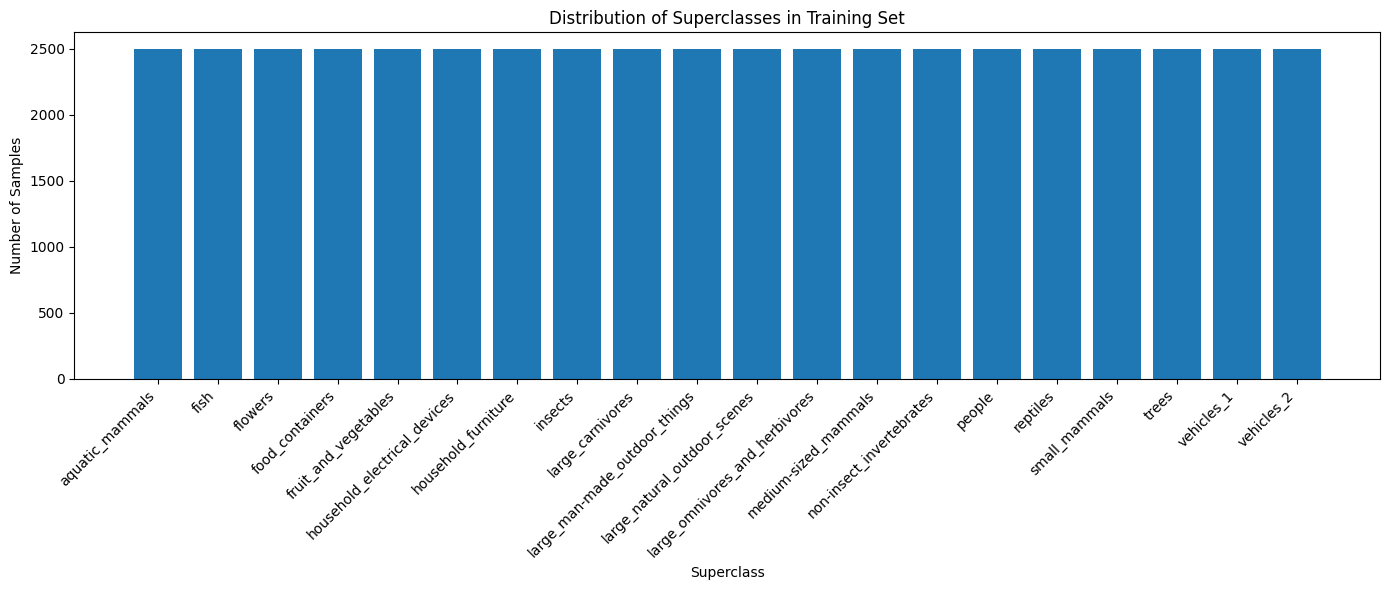

In [8]:
from collections import Counter

superclass_counts = Counter()
for i in range(len(train_dataset)):
    _, fine_label = train_dataset[i]
    coarse_label = FINE_TO_COARSE_MAPPING[fine_label]
    superclass_counts[coarse_label] += 1

print("Distribution of superclasses in training set:")
print(f"Total samples: {sum(superclass_counts.values())}")
print(f"\nSamples per superclass:")
for superclass_id in sorted(superclass_counts.keys()):
    count = superclass_counts[superclass_id]
    print(f"{SUPERCLASS_NAMES[superclass_id]}: {count}")

plt.figure(figsize=(14, 6))
superclass_ids = sorted(superclass_counts.keys())
counts = [superclass_counts[i] for i in superclass_ids]
names = [SUPERCLASS_NAMES[i] for i in superclass_ids]

plt.bar(range(len(names)), counts)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.xlabel('Superclass')
plt.ylabel('Number of Samples')
plt.title('Distribution of Superclasses in Training Set')
plt.tight_layout()
plt.show()


Distribution of fine classes in training set:
Total samples: 50000
Total classes: 100

Samples per class (showing first 10):
  apple: 500
  aquarium_fish: 500
  baby: 500
  bear: 500
  beaver: 500
  bed: 500
  bee: 500
  beetle: 500
  bicycle: 500
  bottle: 500


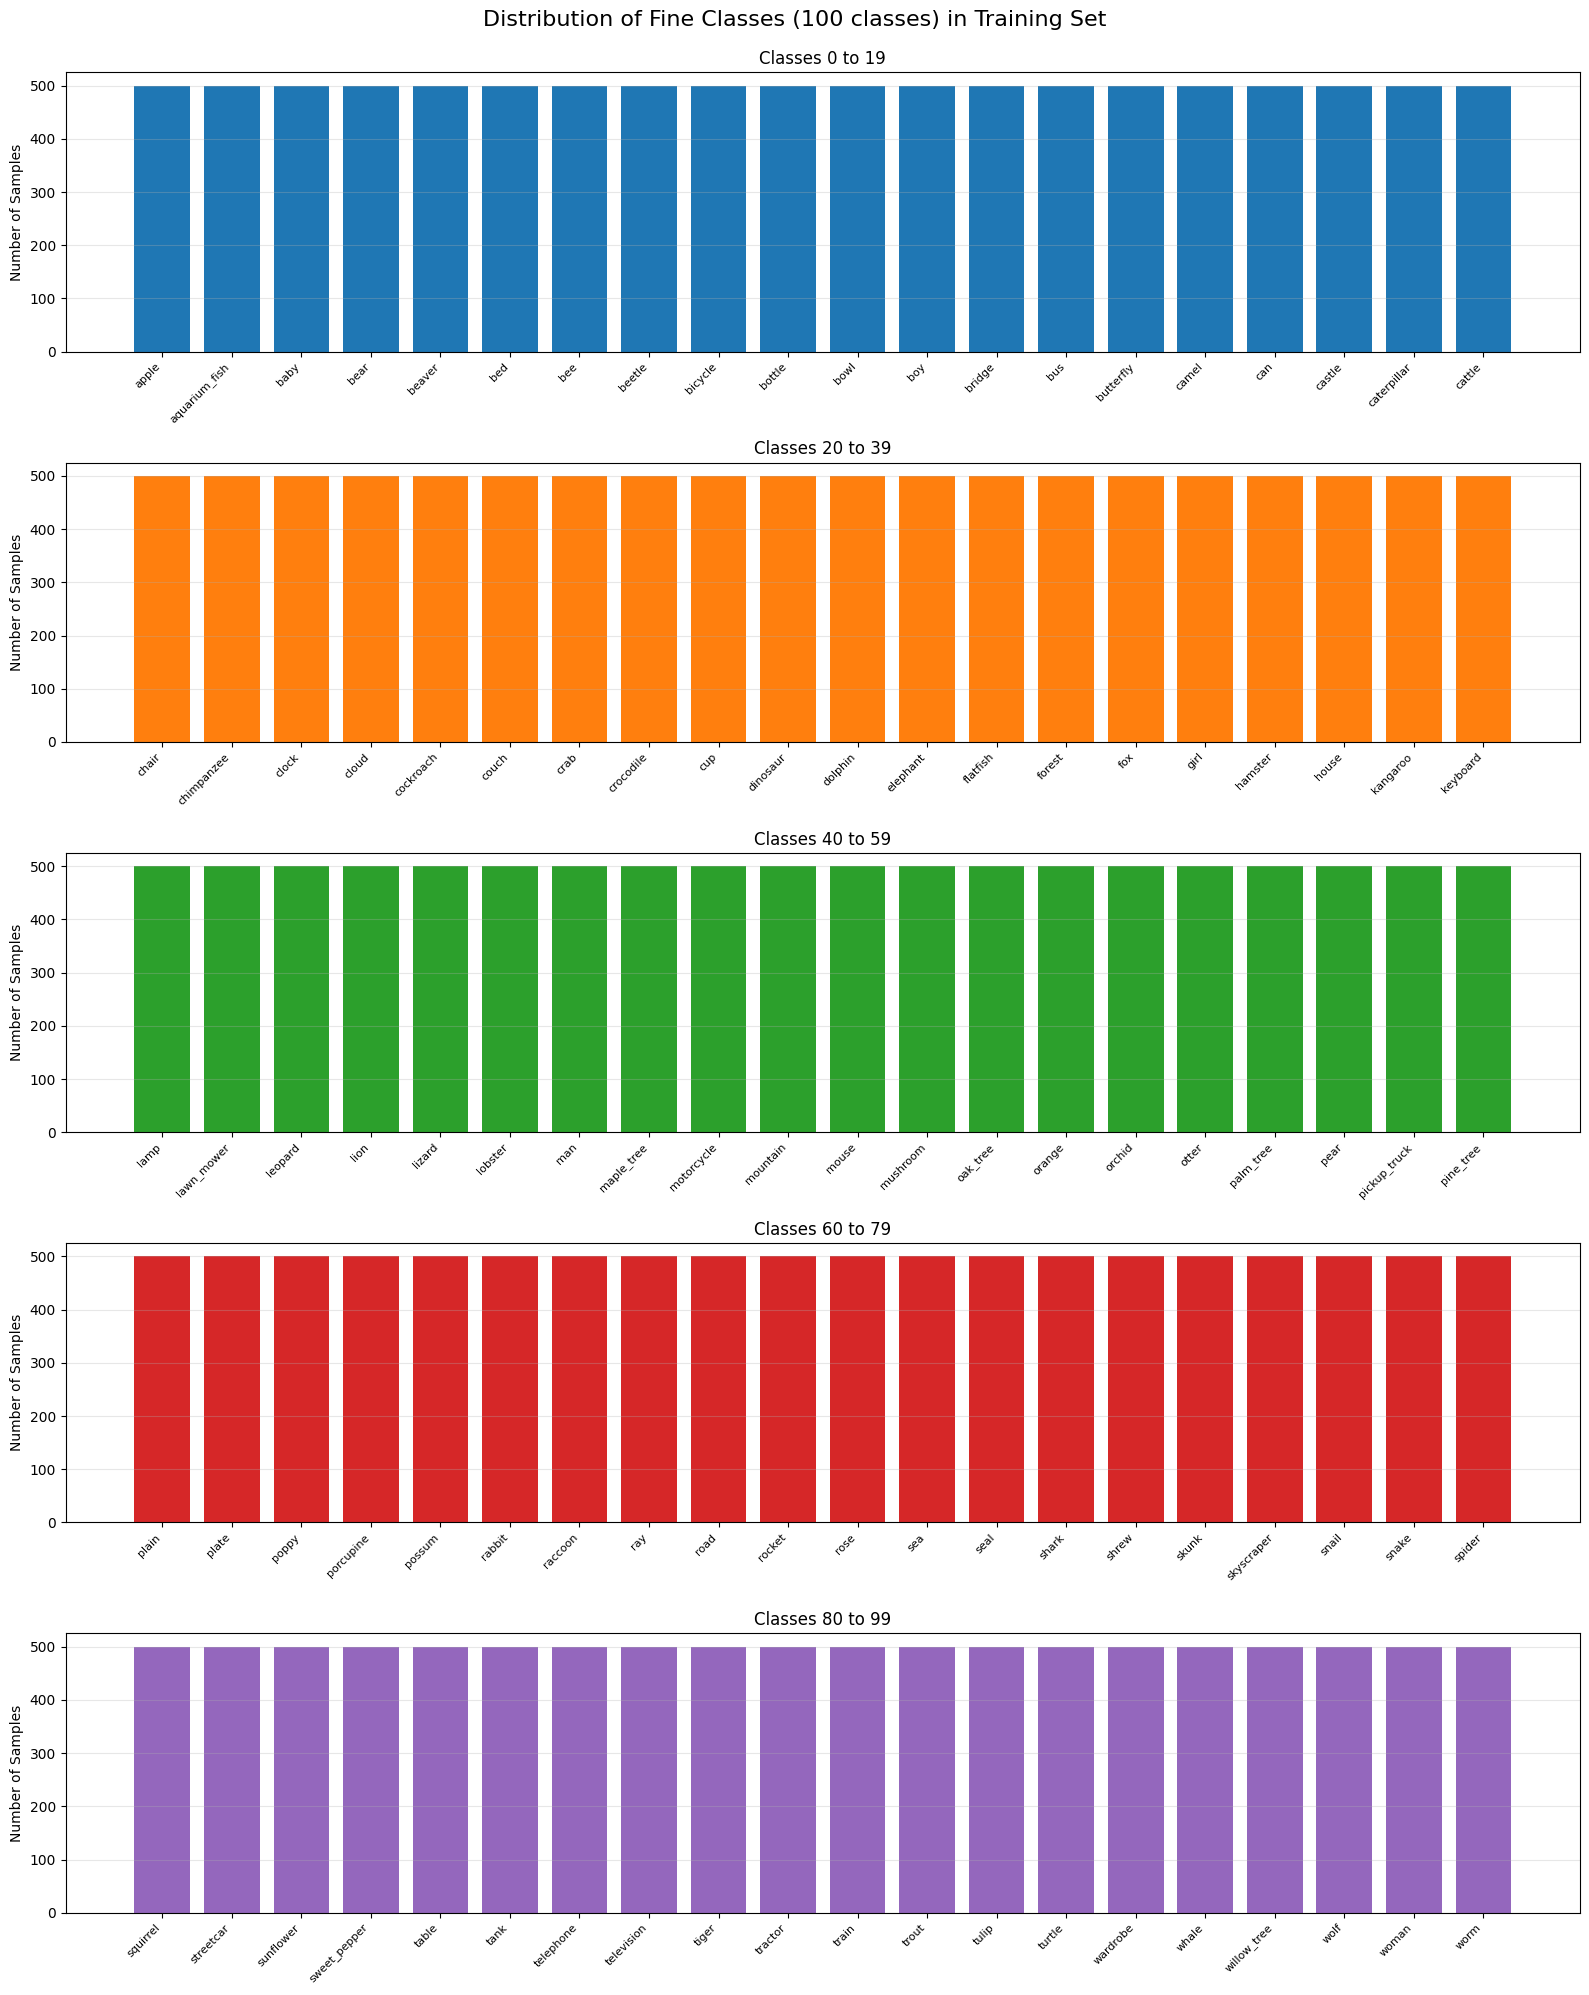

In [9]:
from collections import Counter

fine_class_counts = Counter()
for i in range(len(train_dataset)):
    _, fine_label = train_dataset[i]
    fine_class_counts[fine_label] += 1

print("Distribution of fine classes in training set:")
print(f"Total samples: {sum(fine_class_counts.values())}")
print(f"Total classes: {len(fine_class_counts)}")
print(f"\nSamples per class (showing first 10):")
for class_id in sorted(fine_class_counts.keys())[:10]:
    count = fine_class_counts[class_id]
    class_name = train_dataset.classes[class_id]
    print(f"  {class_name}: {count}")

fig, axes = plt.subplots(5, 1, figsize=(16, 20))
fig.suptitle('Distribution of Fine Classes (100 classes) in Training Set', fontsize=16, y=0.995)

classes_per_plot = 20
for plot_idx in range(5):
    start_idx = plot_idx * classes_per_plot
    end_idx = start_idx + classes_per_plot
    
    class_ids = list(range(start_idx, end_idx))
    counts = [fine_class_counts[i] for i in class_ids]
    names = [train_dataset.classes[i] for i in class_ids]
    
    ax = axes[plot_idx]
    ax.bar(range(len(names)), counts, color=f'C{plot_idx}')
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Classes {start_idx} to {end_idx-1}', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Datasets com boa distribuição

Separar entre 50000, 10000, 10000

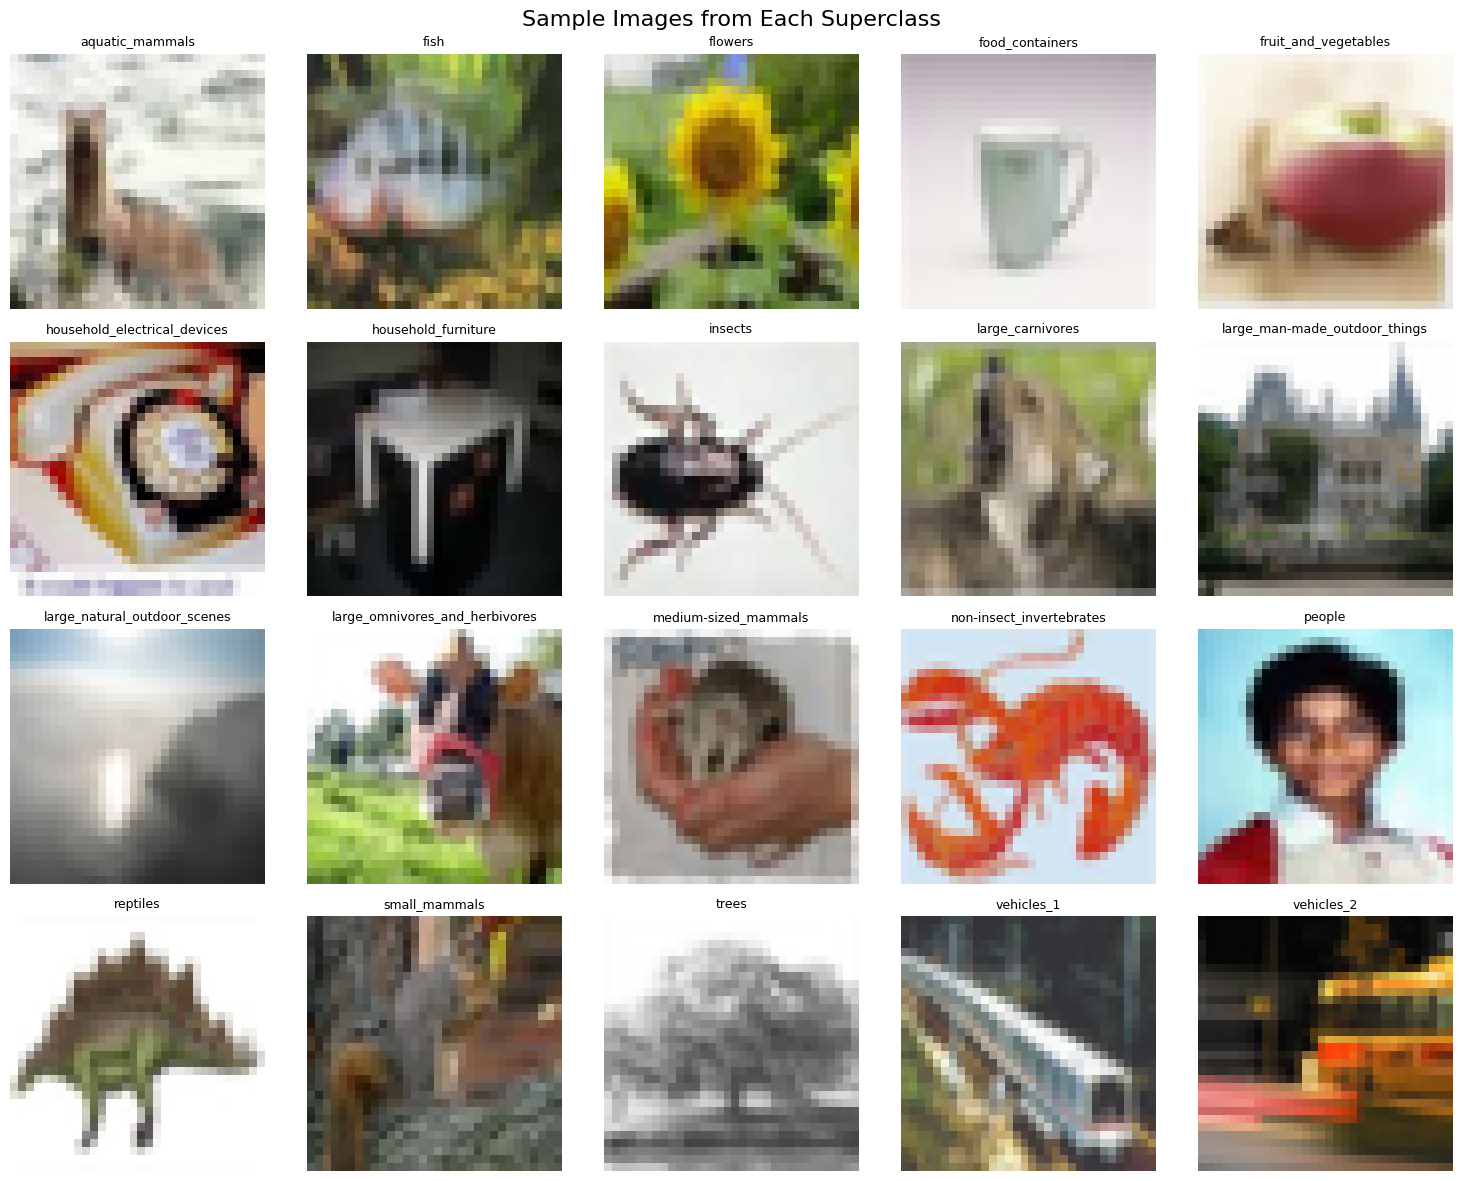

In [10]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Sample Images from Each Superclass', fontsize=16)

superclass_samples = {}
for i in range(len(train_dataset)):
    img, fine_label = train_dataset[i]
    coarse_label = FINE_TO_COARSE_MAPPING[fine_label]
    if coarse_label not in superclass_samples:
        superclass_samples[coarse_label] = i
    if len(superclass_samples) == 20:
        break

for superclass_id in range(20):
    if superclass_id in superclass_samples:
        idx = superclass_samples[superclass_id]
        img, _ = train_dataset[idx]
        
        row = superclass_id // 5
        col = superclass_id % 5
        ax = axes[row, col]
        ax.imshow(img)
        ax.set_title(SUPERCLASS_NAMES[superclass_id], fontsize=9)
        ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2

In [12]:
class SingleHeadModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.backbone = create_backbone()
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

In [13]:
from torchinfo import summary

model = SingleHeadModel(num_classes=100)
summary(model, input_size=(1, 3, 32, 32))

/Users/oliveiraswell/repos/ufms-redes-neurais-2025/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oliveiraswell/repos/ufms-redes-neurais-2025/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
SingleHeadModel                                         [1, 100]                  --
├─MobileNetV2: 1-1                                      [1, 100]                  --
│    └─Sequential: 2-1                                  [1, 1280, 1, 1]           --
│    │    └─Conv2dNormActivation: 3-1                   [1, 32, 16, 16]           928
│    │    └─InvertedResidual: 3-2                       [1, 16, 16, 16]           896
│    │    └─InvertedResidual: 3-3                       [1, 24, 8, 8]             5,136
│    │    └─InvertedResidual: 3-4                       [1, 24, 8, 8]             8,832
│    │    └─InvertedResidual: 3-5                       [1, 32, 4, 4]             10,000
│    │    └─InvertedResidual: 3-6                       [1, 32, 4, 4]             14,848
│    │    └─InvertedResidual: 3-7                       [1, 32, 4, 4]             14,848
│    │    └─InvertedResidual: 3-8       

In [14]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

full_train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset_transformed = CIFAR100(root='./data', train=False, download=True, transform=transform)

train_size = int(TRAIN_SPLIT_RATIO * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset_transformed, val_dataset_transformed = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

print(f"Training samples: {len(train_dataset_transformed)}")
print(f"Validation samples: {len(val_dataset_transformed)}")
print(f"Test samples: {len(test_dataset_transformed)}")

train_loader = DataLoader(
    train_dataset_transformed, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    val_dataset_transformed, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset_transformed, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS
)


Training samples: 40000
Validation samples: 10000
Test samples: 10000


In [15]:
history = {'train_loss': [], 'val_loss': []}
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
cross_entropy_loss = nn.CrossEntropyLoss()
num_epochs = NUM_EPOCHS

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model.to(device)
early_stopping = EarlyStopping(patience=PATIENCE)
autosave_model = SaveModel()
print(f"Training on {device}")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = cross_entropy_loss(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = cross_entropy_loss(output, target)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    
    print("--------------------------------")
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')
    print("--------------------------------")
    
    if autosave_model.should_save(avg_val_loss):
        autosave_model.save(model, optimizer, epoch, avg_train_loss, avg_val_loss, 
                           f'checkpoint_fine_model_epoch_{epoch+1}.pth')
    
    if early_stopping(avg_val_loss, epoch):
        print(f"Early stopping at epoch {epoch+1}")
        break




Training on mps
--------------------------------
Epoch 1/100 - Train Loss: 2.6777 - Val Loss: 2.2559
--------------------------------
Checkpoint saved: checkpoint_fine_model_epoch_1.pth
--------------------------------
Epoch 2/100 - Train Loss: 1.9024 - Val Loss: 2.0229
--------------------------------
Checkpoint saved: checkpoint_fine_model_epoch_2.pth
--------------------------------
Epoch 3/100 - Train Loss: 1.6144 - Val Loss: 1.8960
--------------------------------
Checkpoint saved: checkpoint_fine_model_epoch_3.pth
--------------------------------
Epoch 4/100 - Train Loss: 1.4194 - Val Loss: 1.8974
--------------------------------
--------------------------------
Epoch 5/100 - Train Loss: 1.2481 - Val Loss: 2.0140
--------------------------------
--------------------------------
Epoch 6/100 - Train Loss: 1.2034 - Val Loss: 2.4981
--------------------------------
--------------------------------
Epoch 7/100 - Train Loss: 1.2273 - Val Loss: 1.8428
--------------------------------
Ch

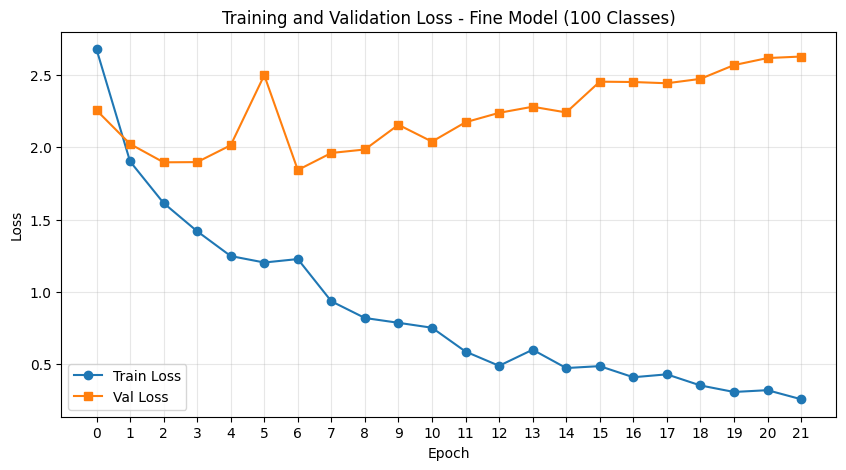

In [16]:
def plot_training_history(history, title='Training and Validation Loss', figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Val Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.xticks(range(len(history['train_loss'])))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_training_history(history, title='Training and Validation Loss - Fine Model (100 Classes)')

In [17]:
from sklearn.metrics import classification_report

model.eval()
test_loss = 0.0
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        
        loss = cross_entropy_loss(output, target)
        test_loss += loss.item()
        
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

print(f"Test Loss: {test_loss / len(test_loader):.4f}\n")
print(classification_report(all_targets, all_preds))

Test Loss: 2.6396

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       100
           1       0.71      0.65      0.68       100
           2       0.50      0.23      0.32       100
           3       0.39      0.27      0.32       100
           4       0.28      0.32      0.30       100
           5       0.45      0.51      0.48       100
           6       0.58      0.69      0.63       100
           7       0.69      0.45      0.55       100
           8       0.70      0.67      0.68       100
           9       0.59      0.71      0.65       100
          10       0.51      0.43      0.47       100
          11       0.42      0.28      0.34       100
          12       0.58      0.54      0.56       100
          13       0.51      0.43      0.46       100
          14       0.54      0.45      0.49       100
          15       0.33      0.56      0.42       100
          16       0.69      0.49      0.57       100
        

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix', 
                          figsize=(16, 14), normalize=False, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        cbar_label = 'Proportion'
    else:
        fmt = 'd'
        cbar_label = 'Count'
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': cbar_label}, ax=ax, 
                square=True, linewidths=0.5)
    
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return cm


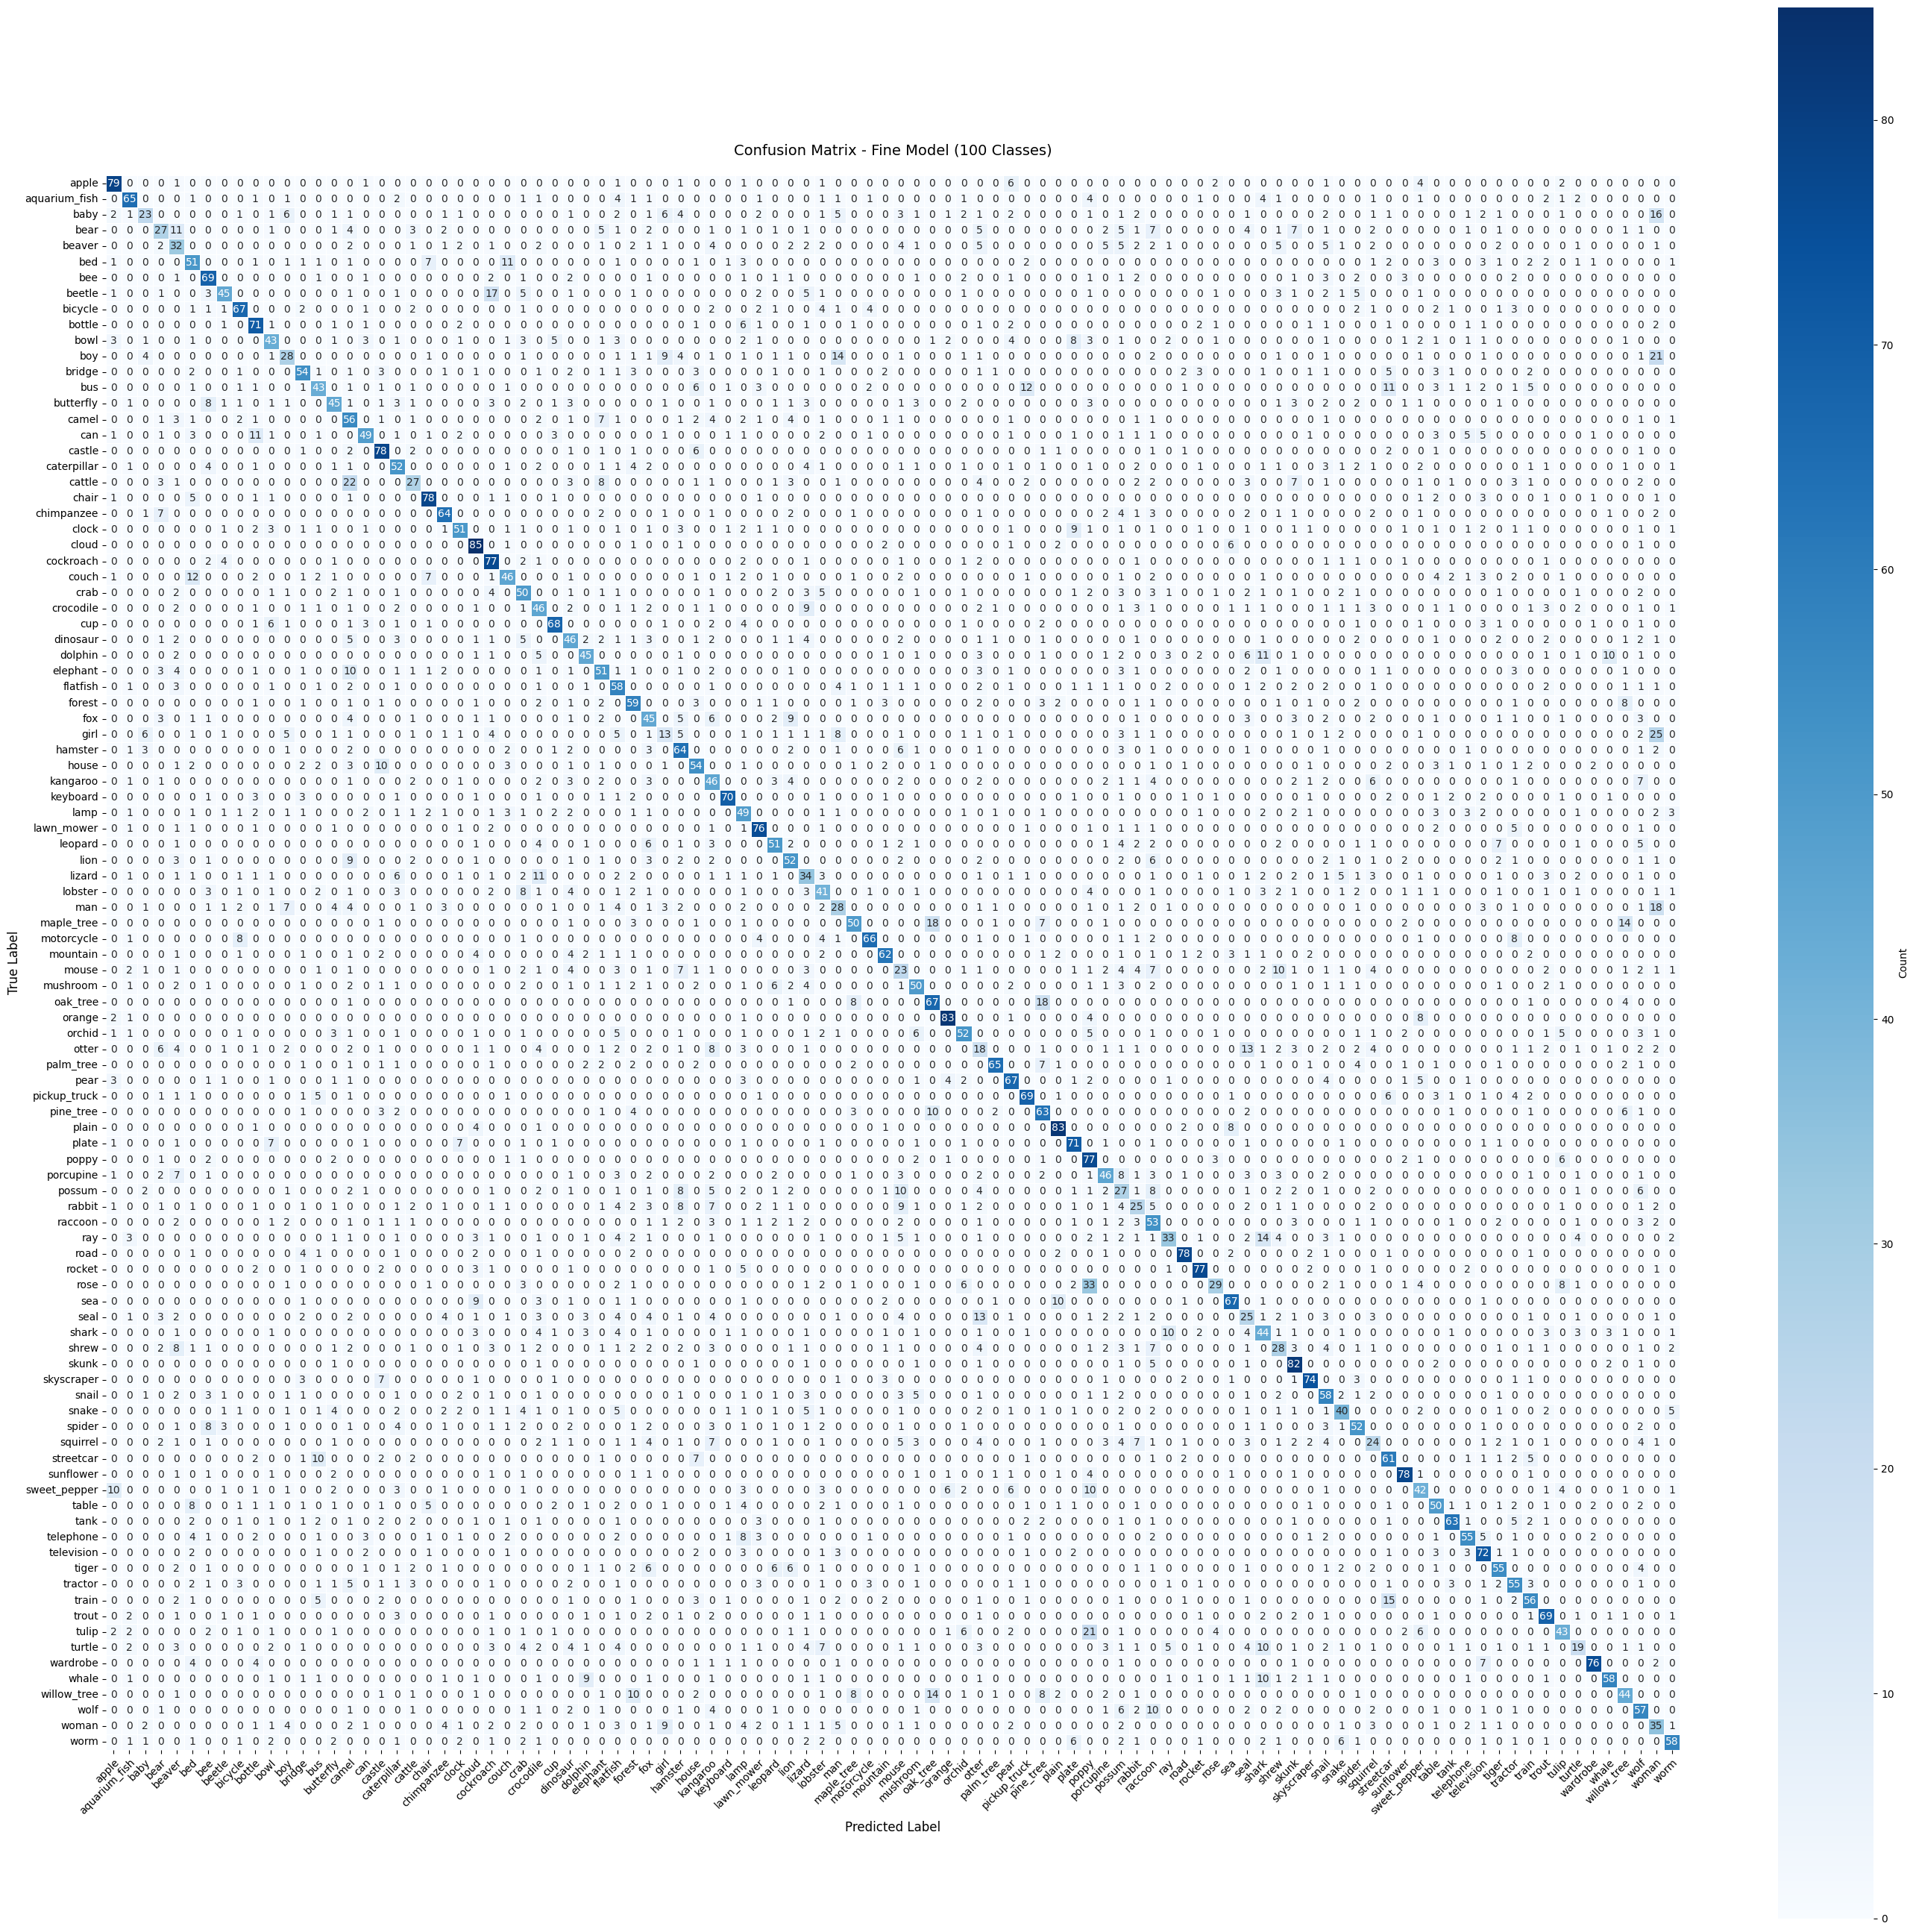

In [19]:
cm_fine = plot_confusion_matrix(
    y_true=all_targets,
    y_pred=all_preds,
    class_names=train_dataset.classes,
    title='Confusion Matrix - Fine Model (100 Classes)',
    figsize=(28, 26),
    normalize=False,
    cmap='Blues'
)


---
# 20 Superclasses

In [20]:
model_coarse = SingleHeadModel(num_classes=20)
summary(model_coarse, input_size=(1, 3, 32, 32))

/Users/oliveiraswell/repos/ufms-redes-neurais-2025/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oliveiraswell/repos/ufms-redes-neurais-2025/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
SingleHeadModel                                         [1, 20]                   --
├─MobileNetV2: 1-1                                      [1, 20]                   --
│    └─Sequential: 2-1                                  [1, 1280, 1, 1]           --
│    │    └─Conv2dNormActivation: 3-1                   [1, 32, 16, 16]           928
│    │    └─InvertedResidual: 3-2                       [1, 16, 16, 16]           896
│    │    └─InvertedResidual: 3-3                       [1, 24, 8, 8]             5,136
│    │    └─InvertedResidual: 3-4                       [1, 24, 8, 8]             8,832
│    │    └─InvertedResidual: 3-5                       [1, 32, 4, 4]             10,000
│    │    └─InvertedResidual: 3-6                       [1, 32, 4, 4]             14,848
│    │    └─InvertedResidual: 3-7                       [1, 32, 4, 4]             14,848
│    │    └─InvertedResidual: 3-8       

In [21]:
history_coarse = {'train_loss': [], 'val_loss': []}
optimizer_coarse = torch.optim.Adam(model_coarse.parameters(), lr=LEARNING_RATE)
criterion_coarse = nn.CrossEntropyLoss()
num_epochs_coarse = NUM_EPOCHS

model_coarse.to(device)
fine_to_coarse_tensor_device = fine_to_coarse_tensor.to(device)
early_stopping_coarse = EarlyStopping(patience=PATIENCE)
autosave_model_coarse = SaveModel()

print(f"Training coarse model (20 superclasses) on {device}")

for epoch in range(num_epochs_coarse):
    model_coarse.train()
    epoch_loss = 0.0
    
    for data, target_fine in train_loader:
        data = data.to(device)
        target_fine = target_fine.to(device)
        
        target_coarse = fine_to_coarse_tensor_device[target_fine]
        
        optimizer_coarse.zero_grad()
        output = model_coarse(data)
        loss = criterion_coarse(output, target_coarse)
        loss.backward()
        optimizer_coarse.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    history_coarse['train_loss'].append(avg_train_loss)

    model_coarse.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target_fine in val_loader:
            data = data.to(device)
            target_fine = target_fine.to(device)
            
            target_coarse = fine_to_coarse_tensor_device[target_fine]
            
            output = model_coarse(data)
            loss = criterion_coarse(output, target_coarse)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    history_coarse['val_loss'].append(avg_val_loss)
    
    print("--------------------------------")
    print(f'Epoch {epoch+1}/{num_epochs_coarse} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')
    print("--------------------------------")
    
    if autosave_model_coarse.should_save(avg_val_loss):
        autosave_model_coarse.save(model_coarse, optimizer_coarse, epoch, avg_train_loss, avg_val_loss,
                                   f'checkpoint_coarse_model_epoch_{epoch+1}.pth')
    
    if early_stopping_coarse(avg_val_loss, epoch):
        print(f"Early stopping at epoch {epoch+1}")
        break


Training coarse model (20 superclasses) on mps
--------------------------------
Epoch 1/100 - Train Loss: 1.6428 - Val Loss: 1.3897
--------------------------------
Checkpoint saved: checkpoint_coarse_model_epoch_1.pth
--------------------------------
Epoch 2/100 - Train Loss: 1.1819 - Val Loss: 1.2702
--------------------------------
Checkpoint saved: checkpoint_coarse_model_epoch_2.pth
--------------------------------
Epoch 3/100 - Train Loss: 0.9921 - Val Loss: 1.2223
--------------------------------
Checkpoint saved: checkpoint_coarse_model_epoch_3.pth
--------------------------------
Epoch 4/100 - Train Loss: 0.8655 - Val Loss: 1.1624
--------------------------------
Checkpoint saved: checkpoint_coarse_model_epoch_4.pth
--------------------------------
Epoch 5/100 - Train Loss: 0.7712 - Val Loss: 1.1385
--------------------------------
Checkpoint saved: checkpoint_coarse_model_epoch_5.pth
--------------------------------
Epoch 6/100 - Train Loss: 0.6954 - Val Loss: 1.2583
--------

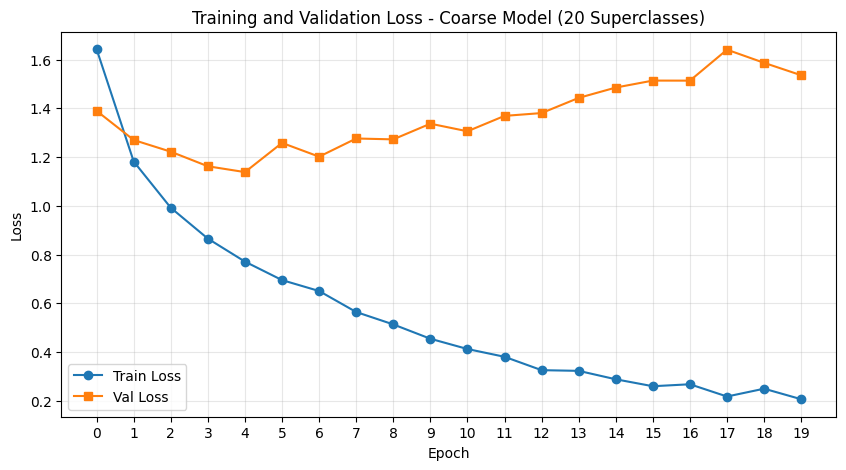

In [22]:
plot_training_history(history_coarse, title='Training and Validation Loss - Coarse Model (20 Superclasses)')


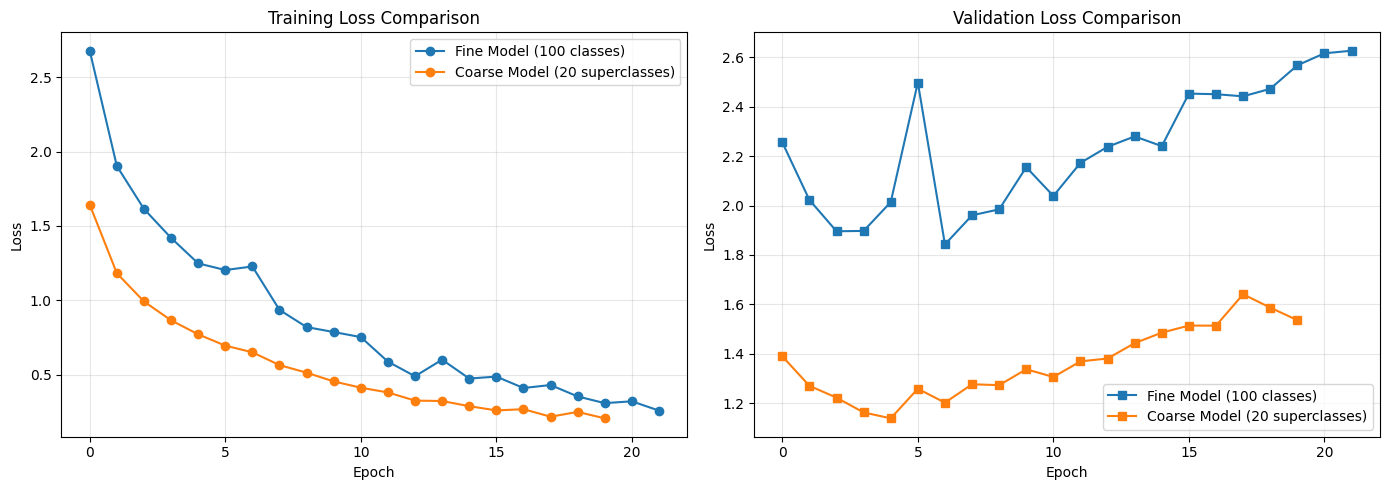

In [23]:
def compare_training_histories(histories_dict, figsize=(14, 5)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for model_name, history in histories_dict.items():
        axes[0].plot(history['train_loss'], label=model_name, marker='o')
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    for model_name, history in histories_dict.items():
        axes[1].plot(history['val_loss'], label=model_name, marker='s')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Validation Loss Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

compare_training_histories({
    'Fine Model (100 classes)': history,
    'Coarse Model (20 superclasses)': history_coarse
})


In [24]:
model_coarse.eval()
test_loss_coarse = 0.0
all_preds_coarse = []
all_targets_coarse = []

with torch.no_grad():
    for data, target_fine in test_loader:
        data = data.to(device)
        target_fine = target_fine.to(device)
        
        target_coarse = fine_to_coarse_tensor_device[target_fine]
        
        output = model_coarse(data)
        loss = criterion_coarse(output, target_coarse)
        test_loss_coarse += loss.item()
        
        pred = output.argmax(dim=1)
        all_preds_coarse.extend(pred.cpu().numpy())
        all_targets_coarse.extend(target_coarse.cpu().numpy())


In [25]:
print(f"Test Loss (Coarse Model): {test_loss_coarse / len(test_loader):.4f}\n")
print("Classification Report - Coarse Model (20 Superclasses):")
print(classification_report(all_targets_coarse, all_preds_coarse, target_names=SUPERCLASS_NAMES))


Test Loss (Coarse Model): 1.5645

Classification Report - Coarse Model (20 Superclasses):
                                precision    recall  f1-score   support

               aquatic_mammals       0.49      0.59      0.54       500
                          fish       0.67      0.53      0.59       500
                       flowers       0.79      0.80      0.79       500
               food_containers       0.77      0.68      0.72       500
          fruit_and_vegetables       0.82      0.72      0.77       500
  household_electrical_devices       0.58      0.72      0.64       500
           household_furniture       0.83      0.68      0.75       500
                       insects       0.62      0.70      0.65       500
              large_carnivores       0.60      0.55      0.57       500
 large_man-made_outdoor_things       0.74      0.76      0.75       500
  large_natural_outdoor_scenes       0.84      0.81      0.82       500
large_omnivores_and_herbivores       0.60    

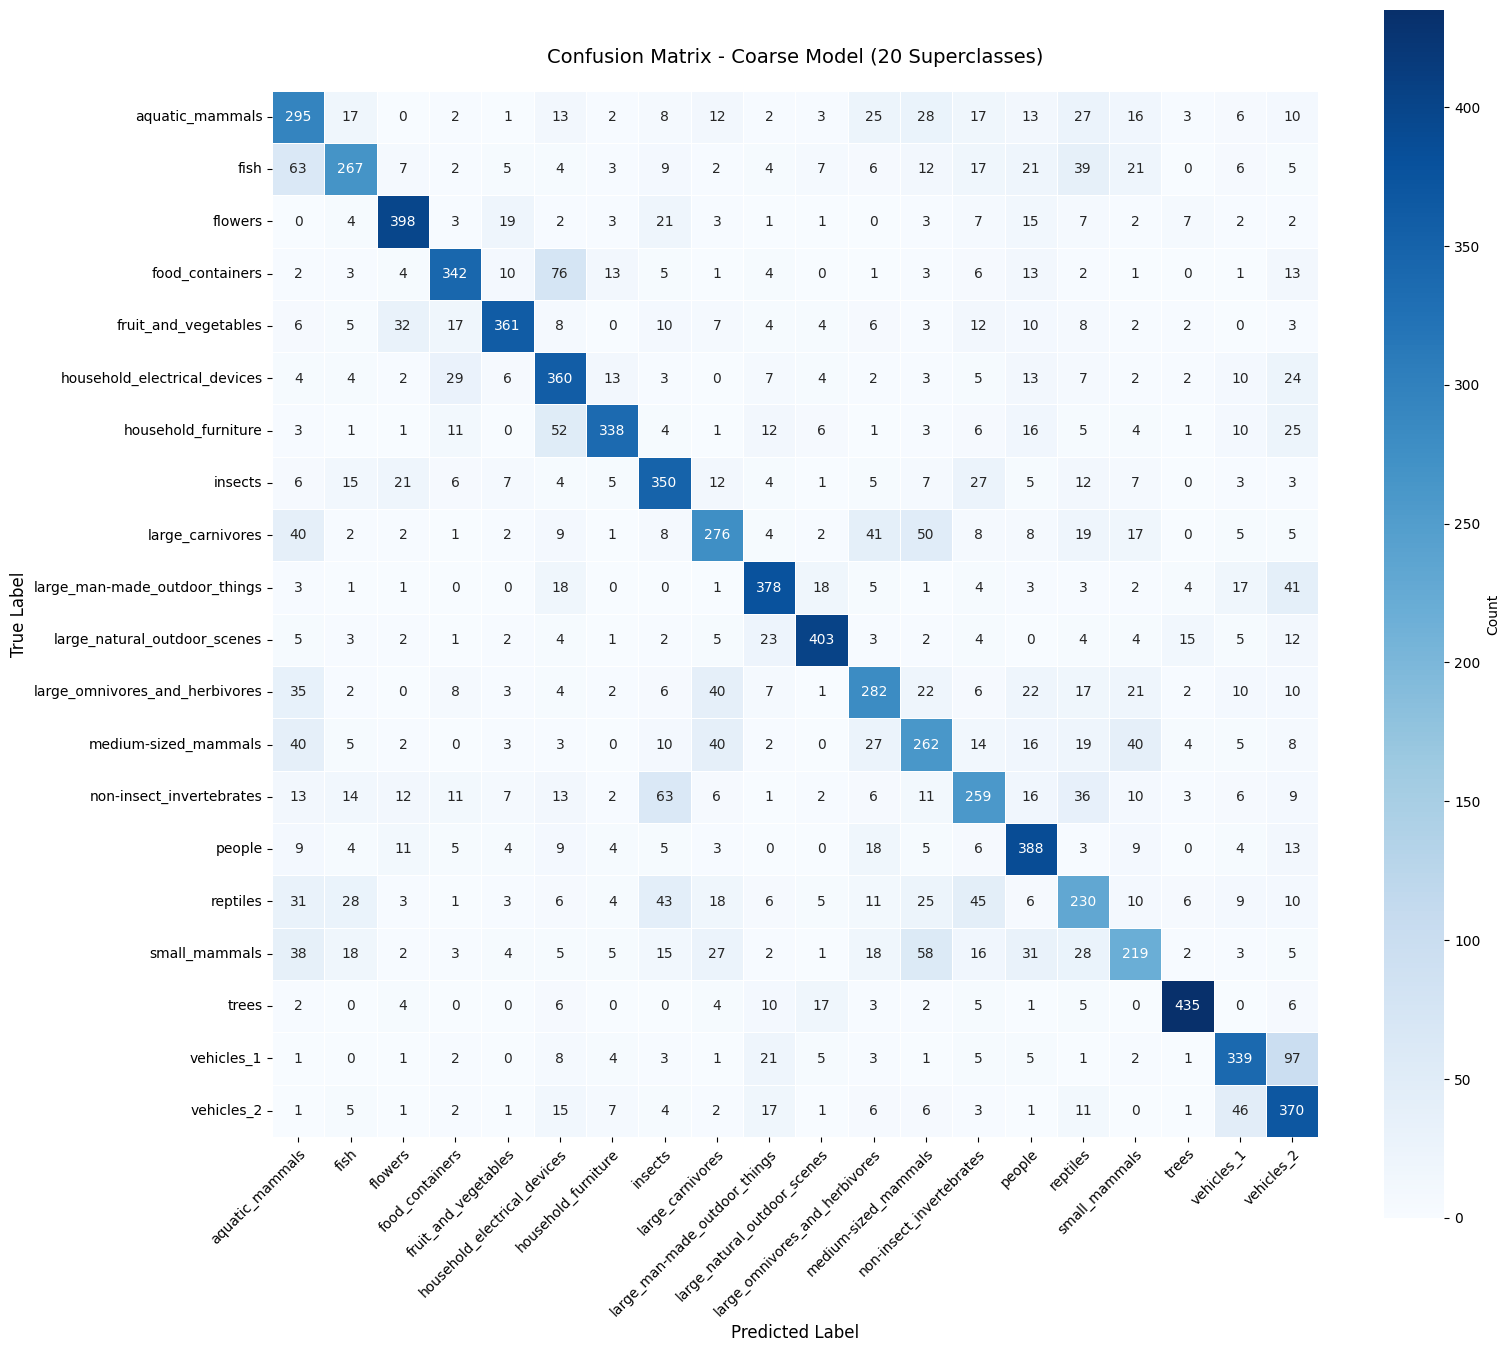

In [26]:
cm_coarse = plot_confusion_matrix(
    y_true=all_targets_coarse,
    y_pred=all_preds_coarse,
    class_names=SUPERCLASS_NAMES,
    title='Confusion Matrix - Coarse Model (20 Superclasses)',
    figsize=(16, 14),
    normalize=False,
    cmap='Blues'
)


---
# Multi Head Model

In [27]:
class MultiHeadModel(nn.Module):
    def __init__(self, num_classes_fine: int, num_classes_coarse: int):
        super().__init__()
        self.backbone = create_backbone()
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        self.head_fine = nn.Linear(in_features, num_classes_fine)
        self.head_coarse = nn.Linear(in_features, num_classes_coarse)
        
    def forward(self, x):
        features = self.backbone(x)
        return self.head_fine(features), self.head_coarse(features)

model_multihead = MultiHeadModel(num_classes_fine=100, num_classes_coarse=20)
summary(model_multihead, input_size=(1, 3, 32, 32))


/Users/oliveiraswell/repos/ufms-redes-neurais-2025/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oliveiraswell/repos/ufms-redes-neurais-2025/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
MultiHeadModel                                          [1, 100]                  --
├─MobileNetV2: 1-1                                      [1, 1280]                 --
│    └─Sequential: 2-1                                  [1, 1280, 1, 1]           --
│    │    └─Conv2dNormActivation: 3-1                   [1, 32, 16, 16]           928
│    │    └─InvertedResidual: 3-2                       [1, 16, 16, 16]           896
│    │    └─InvertedResidual: 3-3                       [1, 24, 8, 8]             5,136
│    │    └─InvertedResidual: 3-4                       [1, 24, 8, 8]             8,832
│    │    └─InvertedResidual: 3-5                       [1, 32, 4, 4]             10,000
│    │    └─InvertedResidual: 3-6                       [1, 32, 4, 4]             14,848
│    │    └─InvertedResidual: 3-7                       [1, 32, 4, 4]             14,848
│    │    └─InvertedResidual: 3-8       

In [28]:
history_multihead = {'train_loss': [], 
                     'train_loss_fine': [], 'train_loss_coarse': [], 
                     'val_loss': [], 'val_loss_fine': [], 'val_loss_coarse': []}
optimizer_multihead = torch.optim.Adam(model_multihead.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model_multihead.to(device)
fine_to_coarse_tensor_device = fine_to_coarse_tensor.to(device)
early_stopping_multihead = EarlyStopping(patience=PATIENCE)
autosave_model_multihead = SaveModel()

print(f"Training multi-head model on {device}")

for epoch in range(NUM_EPOCHS):
    model_multihead.train()
    epoch_loss_total = 0.0
    epoch_loss_fine = 0.0
    epoch_loss_coarse = 0.0
    
    for data, target_fine in train_loader:
        data = data.to(device)
        target_fine = target_fine.to(device)
        target_coarse = fine_to_coarse_tensor_device[target_fine]
        
        optimizer_multihead.zero_grad()
        output_fine, output_coarse = model_multihead(data)
        
        loss_fine = criterion(output_fine, target_fine)
        loss_coarse = criterion(output_coarse, target_coarse)
        loss_total = loss_fine + loss_coarse
        
        loss_total.backward()
        optimizer_multihead.step()
        
        epoch_loss_total += loss_total.item()
        epoch_loss_fine += loss_fine.item()
        epoch_loss_coarse += loss_coarse.item()
    
    avg_train_loss = epoch_loss_total / len(train_loader)
    avg_train_loss_fine = epoch_loss_fine / len(train_loader)
    avg_train_loss_coarse = epoch_loss_coarse / len(train_loader)
    
    history_multihead['train_loss'].append(avg_train_loss)
    history_multihead['train_loss_fine'].append(avg_train_loss_fine)
    history_multihead['train_loss_coarse'].append(avg_train_loss_coarse)

    model_multihead.eval()
    val_loss_total = 0.0
    val_loss_fine = 0.0
    val_loss_coarse = 0.0
    
    with torch.no_grad():
        for data, target_fine in val_loader:
            data = data.to(device)
            target_fine = target_fine.to(device)
            target_coarse = fine_to_coarse_tensor_device[target_fine]
            
            output_fine, output_coarse = model_multihead(data)
            
            loss_fine = criterion(output_fine, target_fine)
            loss_coarse = criterion(output_coarse, target_coarse)
            loss_total = loss_fine + loss_coarse
            
            val_loss_total += loss_total.item()
            val_loss_fine += loss_fine.item()
            val_loss_coarse += loss_coarse.item()
    
    avg_val_loss = val_loss_total / len(val_loader)
    avg_val_loss_fine = val_loss_fine / len(val_loader)
    avg_val_loss_coarse = val_loss_coarse / len(val_loader)
    
    history_multihead['val_loss'].append(avg_val_loss)
    history_multihead['val_loss_fine'].append(avg_val_loss_fine)
    history_multihead['val_loss_coarse'].append(avg_val_loss_coarse)
    
    print("--------------------------------")
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {avg_train_loss:.4f} (Fine: {avg_train_loss_fine:.4f}, Coarse: {avg_train_loss_coarse:.4f})')
    print(f'Val Loss: {avg_val_loss:.4f} (Fine: {avg_val_loss_fine:.4f}, Coarse: {avg_val_loss_coarse:.4f})')
    print("--------------------------------")
    
    if autosave_model_multihead.should_save(avg_val_loss):
        autosave_model_multihead.save(model_multihead, optimizer_multihead, epoch, avg_train_loss, avg_val_loss,
                                     f'checkpoint_multihead_model_epoch_{epoch+1}.pth',
                                     train_loss_fine=avg_train_loss_fine,
                                     train_loss_coarse=avg_train_loss_coarse,
                                     val_loss_fine=avg_val_loss_fine,
                                     val_loss_coarse=avg_val_loss_coarse)
    
    if early_stopping_multihead(avg_val_loss, epoch):
        print(f"Early stop - epoch {epoch+1}")
        break


Training multi-head model on mps
--------------------------------
Epoch 1/100
Train Loss: 4.2787 (Fine: 2.6744, Coarse: 1.6043)
Val Loss: 3.6090 (Fine: 2.2499, Coarse: 1.3592)
--------------------------------
Checkpoint saved: checkpoint_multihead_model_epoch_1.pth
--------------------------------
Epoch 2/100
Train Loss: 3.0879 (Fine: 1.9402, Coarse: 1.1477)
Val Loss: 3.1662 (Fine: 1.9831, Coarse: 1.1830)
--------------------------------
Checkpoint saved: checkpoint_multihead_model_epoch_2.pth
--------------------------------
Epoch 3/100
Train Loss: 2.5931 (Fine: 1.6448, Coarse: 0.9483)
Val Loss: 3.0536 (Fine: 1.9111, Coarse: 1.1425)
--------------------------------
Checkpoint saved: checkpoint_multihead_model_epoch_3.pth
--------------------------------
Epoch 4/100
Train Loss: 2.2513 (Fine: 1.4433, Coarse: 0.8080)
Val Loss: 2.9833 (Fine: 1.8643, Coarse: 1.1191)
--------------------------------
Checkpoint saved: checkpoint_multihead_model_epoch_4.pth
--------------------------------
Ep

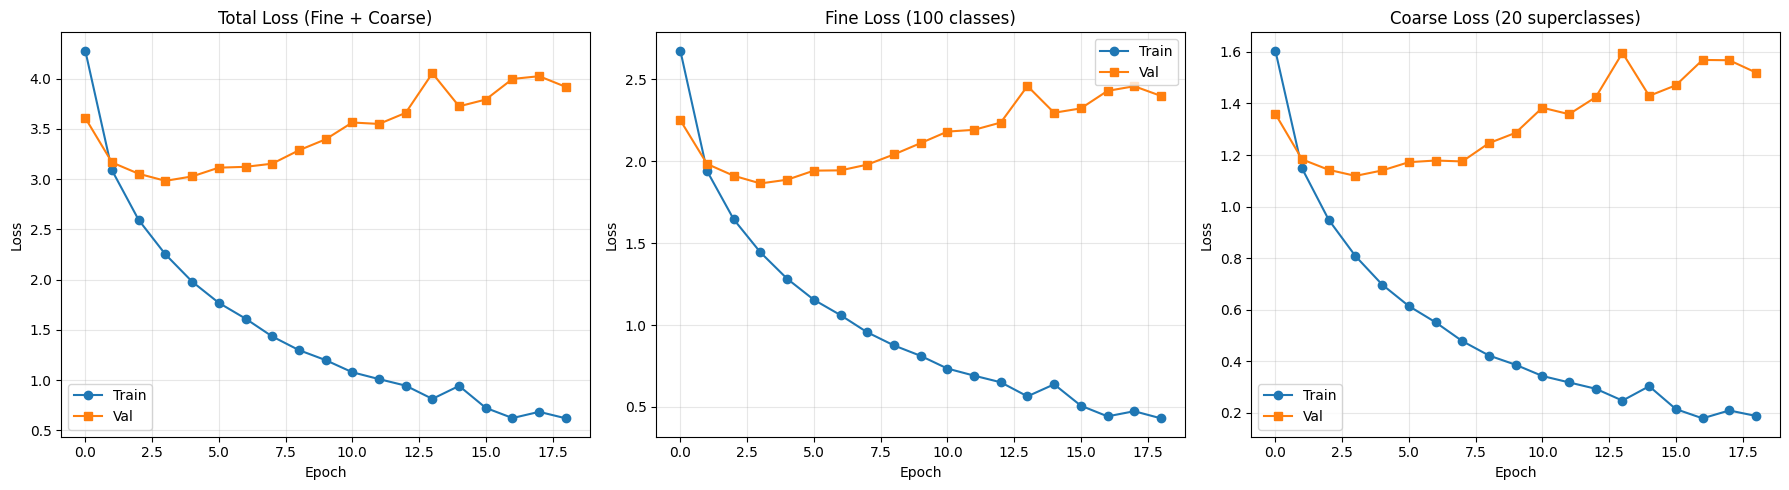

In [29]:
def plot_multihead_training_history(history, figsize=(18, 5)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    axes[0].plot(history['train_loss'], label='Train', marker='o')
    axes[0].plot(history['val_loss'], label='Val', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Total Loss (Fine + Coarse)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history['train_loss_fine'], label='Train', marker='o')
    axes[1].plot(history['val_loss_fine'], label='Val', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Fine Loss (100 classes)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(history['train_loss_coarse'], label='Train', marker='o')
    axes[2].plot(history['val_loss_coarse'], label='Val', marker='s')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Coarse Loss (20 superclasses)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_multihead_training_history(history_multihead)


In [30]:
model_multihead.eval()
test_loss_total = 0.0
test_loss_fine = 0.0
test_loss_coarse = 0.0
all_preds_fine_mh = []
all_targets_fine_mh = []
all_preds_coarse_mh = []
all_targets_coarse_mh = []

with torch.no_grad():
    for data, target_fine in test_loader:
        data = data.to(device)
        target_fine = target_fine.to(device)
        target_coarse = fine_to_coarse_tensor_device[target_fine]
        
        output_fine, output_coarse = model_multihead(data)
        
        loss_fine = criterion(output_fine, target_fine)
        loss_coarse = criterion(output_coarse, target_coarse)
        loss_total = loss_fine + loss_coarse
        
        test_loss_total += loss_total.item()
        test_loss_fine += loss_fine.item()
        test_loss_coarse += loss_coarse.item()
        
        pred_fine = output_fine.argmax(dim=1)
        pred_coarse = output_coarse.argmax(dim=1)
        
        all_preds_fine_mh.extend(pred_fine.cpu().numpy())
        all_targets_fine_mh.extend(target_fine.cpu().numpy())
        all_preds_coarse_mh.extend(pred_coarse.cpu().numpy())
        all_targets_coarse_mh.extend(target_coarse.cpu().numpy())

print(f"Test Loss (Multi-Head Model):")
print(f"  Total: {test_loss_total / len(test_loader):.4f}")
print(f"  Fine: {test_loss_fine / len(test_loader):.4f}")
print(f"  Coarse: {test_loss_coarse / len(test_loader):.4f}")


Test Loss (Multi-Head Model):
  Total: 4.0125
  Fine: 2.4369
  Coarse: 1.5756


In [31]:
print("--------------------------------")
print("CLASSIFICATION REPORT - MULTI-HEAD MODEL (FINE HEAD - 100 Classes)")
print("--------------------------------")
print(classification_report(all_targets_fine_mh, all_preds_fine_mh))

print("--------------------------------")
print("CLASSIFICATION REPORT - MULTI-HEAD MODEL (COARSE HEAD - 20 Superclasses)")
print("--------------------------------")
print(classification_report(all_targets_coarse_mh, all_preds_coarse_mh, target_names=SUPERCLASS_NAMES))


--------------------------------
CLASSIFICATION REPORT - MULTI-HEAD MODEL (FINE HEAD - 100 Classes)
--------------------------------
              precision    recall  f1-score   support

           0       0.60      0.86      0.70       100
           1       0.74      0.66      0.70       100
           2       0.43      0.39      0.41       100
           3       0.39      0.28      0.33       100
           4       0.43      0.20      0.27       100
           5       0.57      0.56      0.56       100
           6       0.51      0.75      0.60       100
           7       0.46      0.59      0.52       100
           8       0.90      0.72      0.80       100
           9       0.72      0.68      0.70       100
          10       0.43      0.39      0.41       100
          11       0.34      0.44      0.38       100
          12       0.57      0.35      0.43       100
          13       0.43      0.45      0.44       100
          14       0.43      0.42      0.43       100
  

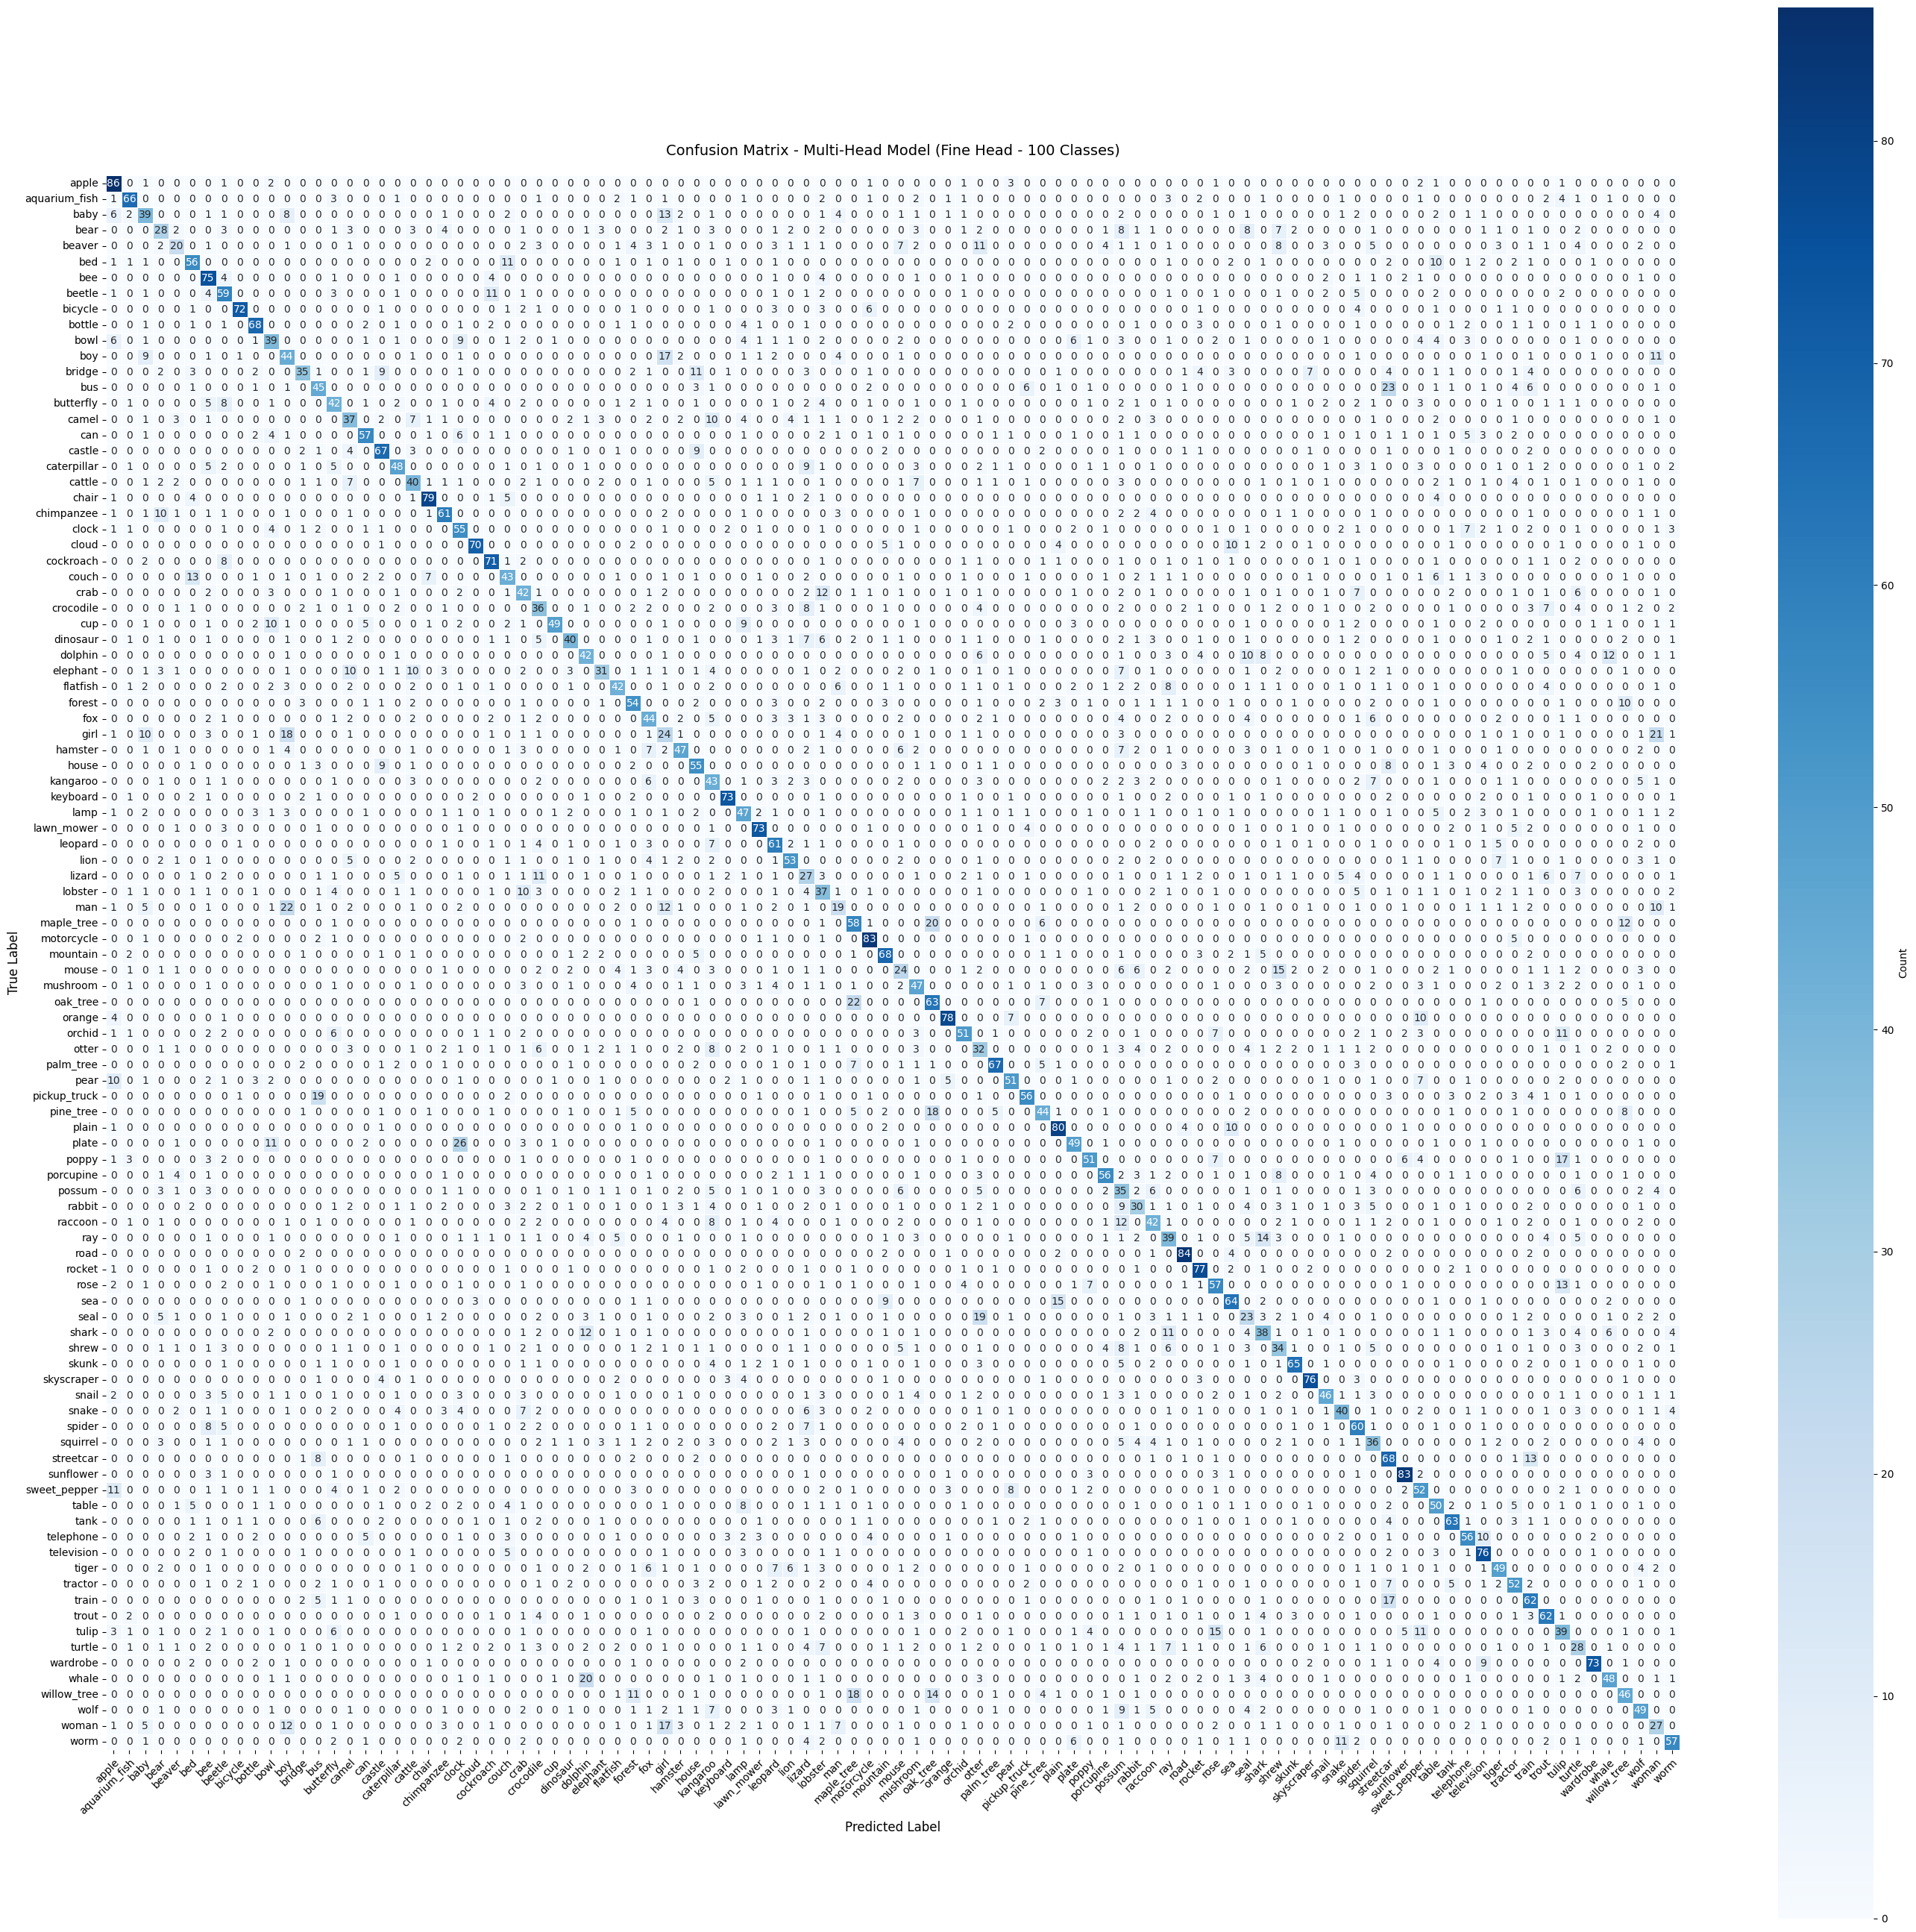

In [32]:
cm_fine_mh = plot_confusion_matrix(
    y_true=all_targets_fine_mh,
    y_pred=all_preds_fine_mh,
    class_names=train_dataset.classes,
    title='Confusion Matrix - Multi-Head Model (Fine Head - 100 Classes)',
    figsize=(28, 26),
    normalize=False,
    cmap='Blues'
)


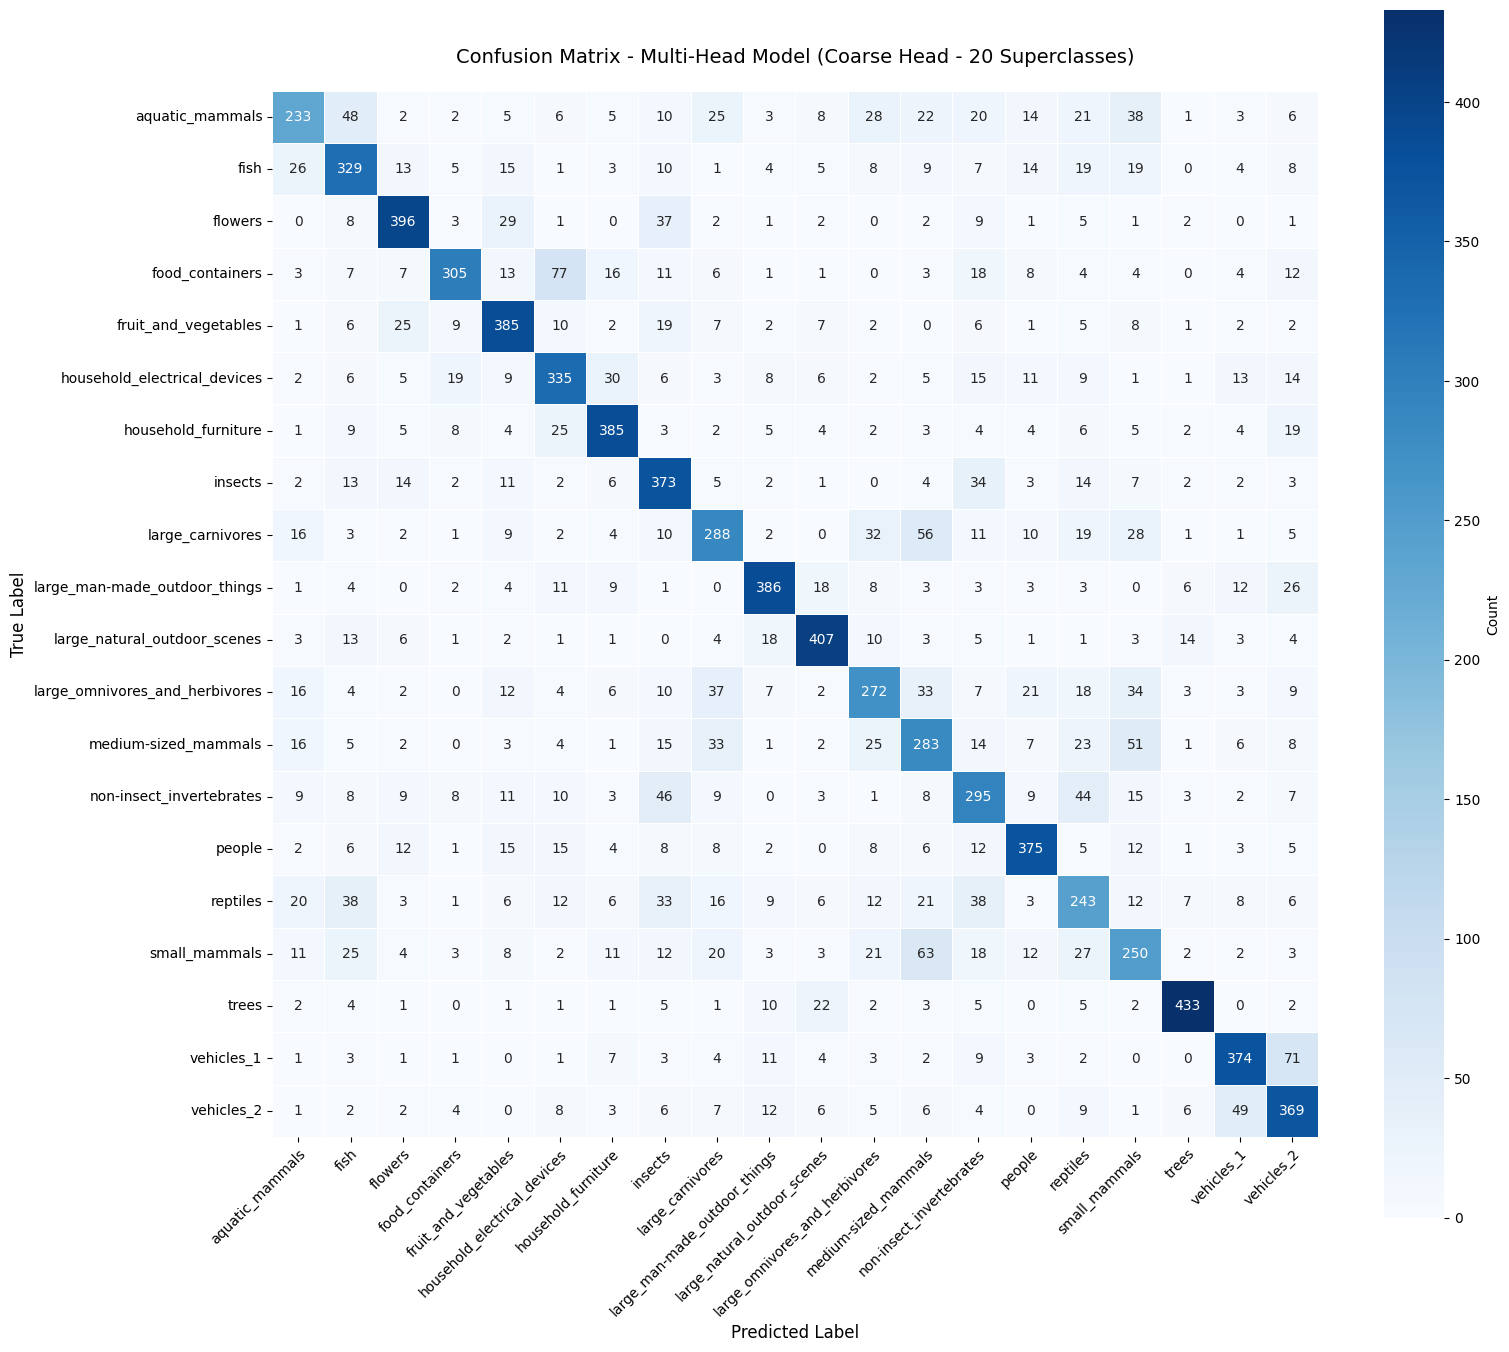

In [33]:
cm_coarse_mh = plot_confusion_matrix(
    y_true=all_targets_coarse_mh,
    y_pred=all_preds_coarse_mh,
    class_names=SUPERCLASS_NAMES,
    title='Confusion Matrix - Multi-Head Model (Coarse Head - 20 Superclasses)',
    figsize=(16, 14),
    normalize=False,
    cmap='Blues'
)
